Last update: May 26th, 2024 

# Oblique QLT 

##### [V. Roytershteyn and G. L. Delzanno. *Nonlinear coupling of whistler waves to oblique electrostatic turbulence enabled by cold plasma*. Physics of Plasmas, 28(4):042903, 04 2021](https://pubs.aip.org/aip/pop/article-abstract/28/4/042903/263604/Nonlinear-coupling-of-whistler-waves-to-oblique?redirectedFrom=fulltext)

Author: Opal Issan (oissan@ucsd.edu)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import wofz 
import scipy
from scipy.sparse import diags
from QLT_equations.testoblique import dydt 

In [2]:
%matplotlib inline
import matplotlib
font = {'family' : 'serif',
        'size'   : 14}

matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 

### Oblique electrostatic waves
The dispersion relation is 
\begin{equation*}
    k_{\perp}^2 + k_{\|}^2 + \frac{2n_{c}\omega_{pe}^2}{\alpha_{\| c}^2} \left[ 1 +   \sum_{n=-\infty}^{\infty} \exp(-\lambda_{c}) I_{n}(\lambda_{c}) Z(\xi_{c}^{n}) \left[\xi_{c}^{0} +  \frac{n \Omega_{ce}}{k_{\|} \alpha_{\| c}} \left[ 1-\frac{T_{\| c}}{T_{\perp c}} \right]\right]\right] = \frac{\omega_{pi}^2}{\alpha_{i}^2} \left|J_{1}\left(\frac{k_{\perp} |V_{Dc}|}{\omega_{0}}\right)\right|^2 Z'\left(\frac{\omega -\omega_{0}}{k \alpha_{i}}\right).
\end{equation*}
\begin{align*}
    k &\coloneqq \|\vec{k}\|_{2} = \sqrt{k_{\perp}^2 + k_{\|}^2}\\
    \lambda_{c} &\coloneqq \frac{k_{\perp}^2 \alpha_{\|c}^2}{2} \\
    \xi_{c}^{n} &\coloneqq \frac{\omega - n}{k_{\|} \alpha_{\|c}}
\end{align*} 

In [3]:
# parameters from 2021 paper 
# normalization (vadim parameters)
# time is normalized to the electron cyclotron frequency 1/Omega_ce
# space is normalized to electron inertial length d_e
omega_0 = 0.5 # Omega_ce
omega_pe = 4 # Omgea_{ce}

n_c = 4/5 # n^e_0

# thermal velocity 
alpha_c_par = 0.0079 # d_e x Omega_ce
alpha_c_perp = 0.0079 # d_e x Omega_ce
alpha_i =  alpha_c_par / np.sqrt(1836) # d_e x Omega_ce

v_0 = 0.65 * alpha_c_par # d_e x Omega_ce
omega_pi = omega_pe / np.sqrt(1836) # Omega_ce

# initial conditions
E0 = 1e-9
K_perp_0 = (alpha_c_perp**2 / 2) * n_c
K_par_0 = (alpha_c_perp**2 / 2) * n_c
T_perp_0 = (alpha_c_perp**2 / 2) 
T_par_0 = (alpha_c_par**2 / 2) 
k_0 = 1 # d_e
dB0 = 4*np.pi * (5e-5) # d_{e}^3 Omega_{ce}^2 m_{e} n_{e}

# max time 
t_max = 600

In [4]:
k_perp_ = np.linspace(15, 60, 120)
k_par_ = np.sqrt((omega_0**2) / (1-omega_0**2))*k_perp_
sol_ = np.zeros((len(k_perp_)), dtype="complex128")
k_abs = np.zeros((len(k_perp_)))

In [5]:
dk_perp = np.abs(k_perp_[1] - k_perp_[0])
dk_par = np.abs(k_par_[1] - k_par_[0])

# QLT equations
\begin{align*}
    \frac{\mathrm{d} K_{\perp c}}{\mathrm{d} t} &= \frac{n_{c}}{2\pi}  \frac{\omega_{pe}^2}{\alpha_{\| c}^2} \int \mathrm{d} \vec{k} \frac{\mathcal{E}_{E}(\vec{k}, t)}{|\vec{k}|^2} \mathrm{Im}\left\{\sum_{n=-\infty}^{\infty} n \exp(-\lambda_{c})  I_{n}(\lambda_{c}) \left[\xi_{c}^{0} + \frac{n}{k_{\|} \alpha_{\| c} } \left[\frac{\alpha_{\| c}^2}{\alpha_{\perp c}^2} - 1\right] \right] Z(\xi_{c}^{n})\right\}\\
    \frac{\mathrm{d} K_{\| c}}{\mathrm{d} t} &=\frac{n_{c}}{\pi}  \frac{\omega_{pe}^2}{\alpha_{\| c}^2} \int \mathrm{d} \vec{k} \frac{\mathcal{E}_{E}(\vec{k}, t)}{|\vec{k}|^2}\mathrm{Im} \left\{\omega +  \sum_{n=-\infty}^{\infty} \exp(-\lambda_{c}) I_{n}(\lambda_{c}) \left\{\omega  + n \left[\frac{\alpha_{\| c}^2}{\alpha_{\perp c}^2} - 1\right]   \right] \xi_{c}^{n}Z(\xi_{c}^{n}) \right\}\\
    \frac{\mathrm{d} T_{\perp c}}{\mathrm{d} t} &= \frac{\omega_{pe}^2}{ 2\sqrt{\pi} \alpha_{\| c}^2} \int \mathrm{d} \vec{k} \frac{\mathcal{E}_{E}(\vec{k}, t)}{|\vec{k}|^2}   \sum_{n=-\infty}^{\infty} n \exp(-\lambda_{c}) I_{n}(\lambda_{c})\left[\mathrm{Re}\{\xi_{c}^{0}\} + \frac{n}{k_{\|} \alpha_{\| c}} \left[\frac{\alpha_{\| c}^2}{\alpha_{\perp c}^2} -1 \right] \right] \exp\left(-\mathrm{Re}\{\xi_{c}^{n}\}^2 \right) \\
    \frac{\mathrm{d} T_{\| c}}{\mathrm{d} t} &= \frac{\omega_{pe}^2}{\sqrt{\pi} \alpha_{\| c}^2} \int \mathrm{d} \vec{k} \frac{\mathcal{E}_{E}(\vec{k}, t)}{|\vec{k}|^2} \sum_{n=-\infty}^{\infty} \exp(-\lambda_{c}) I_{n}(\lambda_{c}) \left[ \mathrm{Re}\{\omega\} + n \left[\frac{\alpha_{\| c}^2 }{\alpha_{\perp c}^2 } -1\right] \right] \mathrm{Re}\{\xi_{c}^{n}\} \exp\left(-\mathrm{Re}\{\xi_{c}^{n}\}^2 \right) \\
    \partial_{t} \mathcal{E}_{E}(k_{\perp}, t)  &= 2 \mathrm{Im}\{\omega\}  \mathcal{E}_{E}(\vec{k}, t) \\
    \partial_{t} \int_{0}^{\infty} \mathrm{d} k_{\|}  \mathcal{E}_{B}(k_{\|}, t) &= \frac{4\pi}{\frac{\omega_{0}^2}{k_{\|0}^2 \omega_{pe}^2} + 1} \left[ -\frac{\mathrm{d} K_{\perp c}}{\mathrm{d} t} - \frac{\mathrm{d} K_{\| c}}{\mathrm{d} t} - \frac{1}{\pi} \int_{0}^{\infty} \int_{0}^{\infty} \mathrm{d} k_{\perp} \mathrm{d} k_{\|}\mathrm{Im} \{ \omega\} \mathcal{E}_{E}(\vec{k}, t) \right]\\
    \frac{\mathrm{d} |V_{Dc}(t)|^2}{\mathrm{d} t} &= \frac{1}{4\pi} \left[\frac{\omega_{0}}{k_{\|0}}\frac{1}{\omega_{0} -1} \right]^2 \partial_{t} \int_{0}^{\infty} \mathrm{d} k_{\|}  \mathcal{E}_{B}(k_{\|}, t)\\
    |\vec{k}|^2 + 2 n_{c} \frac{\omega_{pe}^2}{\alpha_{\| c}^2} &\left[ 1 +   \sum_{n=-\infty}^{\infty} \exp(-\lambda_{c}) I_{n}(\lambda_{c}) Z(\xi_{c}^{n}) \left[\xi_{c}^{0} + \frac{n}{k_{\|} \alpha_{\| c}} \left[\frac{\alpha_{\| c}^2}{\alpha_{\perp c}^2} -1\right]\right]\right] = \frac{\omega_{pi}^2}{\alpha_{i}^2} \left|J_{1}\left(\frac{k_{\perp} |V_{Dc}|}{\omega_{0}}\right)\right|^2 Z'\left(\frac{\omega -\omega_{0}}{k \alpha_{i}}\right)\\
    \lambda_{c} &\coloneqq \frac{k_{\perp}^2 \alpha_{\perp c}^2}{2} \\
    \xi_{c}^{n} &\coloneqq \frac{\omega - n}{k_{\|} \alpha_{c\|}}
\end{align*}


In [6]:
dE_init = E0 * np.ones(len(k_perp_))

# simulate 
result = scipy.integrate.solve_ivp(fun=dydt, t_span=[0, t_max], 
                                   y0=np.concatenate(([K_perp_0], [K_par_0], [T_perp_0], [T_par_0], [dB0], [v_0**2], dE_init)), 
                                   args=(k_perp_, k_par_, omega_pe, omega_pi, k_0, alpha_i, n_c, dk_perp, dk_par, omega_0),
                                   atol=1e-5, rtol=1e-5, 
                                   method='RK45')

t =  0.0
max gamma =  0.009772008223408048
dispersion relation failed to converge
k|| 3.4641016151377544
k|_ 6.0
dispersion relation failed to converge
k|| 5.560028642784126
k|_ 9.630252100840336
t =  225.27598009378892
max gamma =  0.00965041697097605
dispersion relation failed to converge
k|| 5.29803776432833
k|_ 9.176470588235293
t =  0.04184102882701311
max gamma =  0.009771984829251013
t =  0.06276154324051966
max gamma =  0.00977197313154404
t =  0.16736411530805245
max gamma =  0.009771914598048893
dispersion relation failed to converge
k|| 9.751882698076871
k|_ 16.89075630252101
t =  0.18596012812005827
max gamma =  0.009771904131675932
t =  0.20920514413506555
max gamma =  0.00977189110108069
dispersion relation failed to converge
k|| 14.991700267192803
k|_ 25.96638655462185
dispersion relation failed to converge
k|| 15.253691145648599
k|_ 26.42016806722689
t =  0.20920514413506555
max gamma =  0.009771891183402943
t =  0.3547946188694312
max gamma =  0.009771810002143144
t = 

/Users/oissan/PycharmProjects/QLT_whistler/QLT_equations/general_plasma_equations.py:20: RuntimeWarning: invalid value encountered in scalar multiply
  return 1j * np.sqrt(np.pi) * wofz(z)
/opt/anaconda3/envs/rom/lib/python3.9/site-packages/scipy/optimize/_zeros_py.py:382: RuntimeWarning: invalid value encountered in scalar divide
  p = (-q1 / q0 * p0 + p1) / (1 - q1 / q0)


dispersion relation failed to converge
k|| 34.11703439446595
k|_ 59.09243697478992
dispersion relation failed to converge
k|| 34.64101615137754
k|_ 60.0
t =  403.92605288417303
max gamma =  0.006248023235600272
dispersion relation failed to converge
k|| 34.64101615137754
k|_ 60.0
t =  405.3941562273029
max gamma =  0.0061763422763369095
dispersion relation failed to converge
k|| 4.51206512896094
k|_ 7.815126050420168
dispersion relation failed to converge
k|| 8.441928305797889
k|_ 14.621848739495798
dispersion relation failed to converge
k|| 34.37902527292175
k|_ 59.54621848739496
dispersion relation failed to converge
k|| 34.64101615137754
k|_ 60.0
t =  405.3941562273029
max gamma =  0.0061762980444306495
dispersion relation failed to converge
k|| 34.11703439446595
k|_ 59.09243697478992
dispersion relation failed to converge
k|| 34.37902527292175
k|_ 59.54621848739496
dispersion relation failed to converge
k|| 34.64101615137754
k|_ 60.0
t =  407.98785321855513
max gamma =  0.006046438

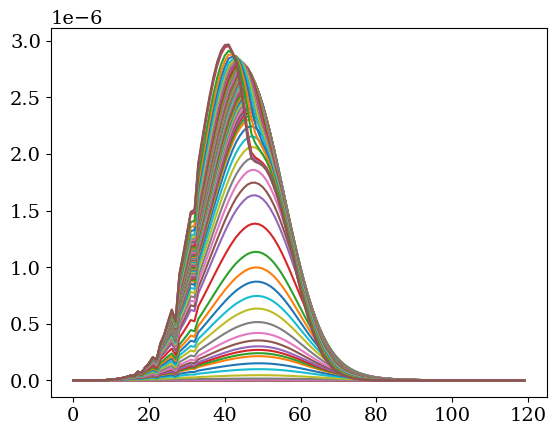

In [7]:
plt.plot(result.y[6:,:])

Text(0.5, 1.0, '$\\mathcal{E}_{E}(|\\vec{k}|, t)$')

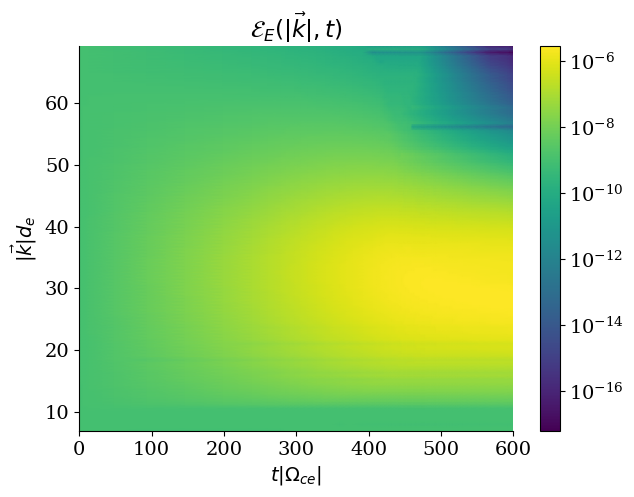

In [8]:
fig, ax = plt.subplots(figsize=(7, 5))
pos = ax.pcolormesh(result.t, np.sqrt(k_perp_**2 + k_par_**2), result.y[6:], cmap="viridis", 
                    norm=matplotlib.colors.LogNorm(), shading='gouraud')
cbar = fig.colorbar(pos)

ax.set_xlabel(r'$t|\Omega_{ce}|$')
ax.set_ylabel(r'$|\vec{k}| d_{e}$')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_title(r"$\mathcal{E}_{E}(|\vec{k}|, t)$")

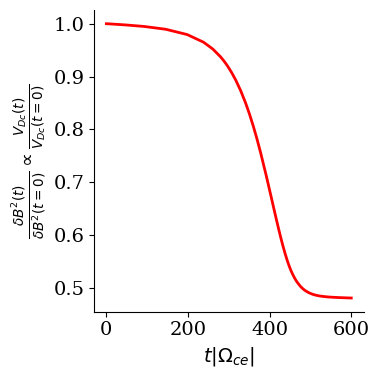

In [9]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.plot(result.t, result.y[4, :]/result.y[4, 0], color="red", linewidth=2)

ax.set_xlabel("$t|\Omega_{ce}|$")
ax.set_ylabel(r"$\frac{\delta B^2(t)}{\delta B^2(t=0)} \propto \frac{V_{Dc}(t)}{V_{Dc}(t=0)}$")

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.tight_layout()

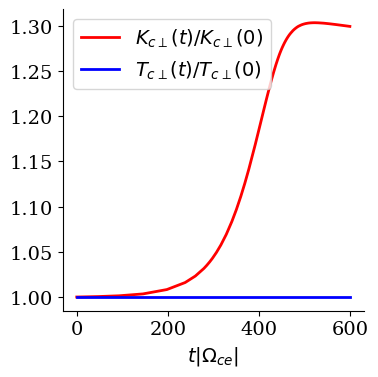

In [11]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.plot(result.t, result.y[0, :]/result.y[0, 0], color="red", linewidth=2, label="$K_{c\perp}(t)/K_{c\perp}(0)$")
ax.plot(result.t, result.y[2, :]/result.y[2, 0], color="blue", linewidth=2, label="$T_{c\perp}(t)/T_{c\perp}(0)$")

ax.legend()
ax.set_xlabel("$t|\Omega_{ce}|$")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.tight_layout()

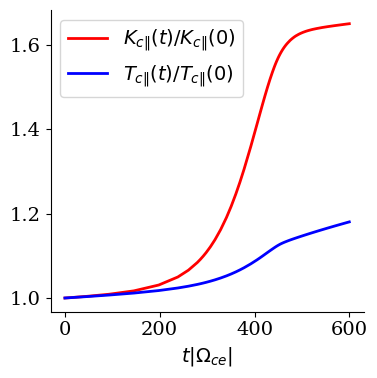

In [12]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.plot(result.t, result.y[1, :]/result.y[1, 0], color="red", linewidth=2, label="$K_{c\|}(t)/K_{c\|}(0)$")
ax.plot(result.t, result.y[3, :]/result.y[3, 0], color="blue", linewidth=2, label="$T_{c\|}(t)/T_{c\|}(0)$")

ax.legend()
ax.set_xlabel("$t|\Omega_{ce}|$")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.tight_layout()

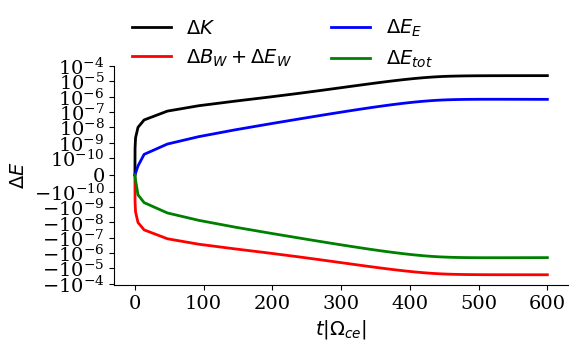

In [19]:
fig, ax = plt.subplots(figsize=(6, 4))
kinetic_energy = result.y[0, :] + 0.5 * result.y[1, :]
potential_energy = np.sum(result.y[6:, :], axis=0)*dk_perp*dk_par/(4*np.pi)
magnetic_energy = (1 + (omega_0/k_0/omega_pe)**2) * result.y[4, :]/(4*np.pi) 
total_energy = kinetic_energy + magnetic_energy + potential_energy 

ax.plot(result.t, kinetic_energy - kinetic_energy[0], color="black", linewidth=2, label="$\Delta K$")
ax.plot(result.t, magnetic_energy - magnetic_energy[0], color="red", linewidth=2, label="$\Delta B_{W} + \Delta E_{W}$")
ax.plot(result.t, potential_energy - potential_energy[0], color="blue", linewidth=2, label="$\Delta E_{E}$")
ax.plot(result.t, total_energy - total_energy[0], color="green", linewidth=2, label="$\Delta E_{tot}$")

ax.set_yscale("symlog", linthresh=1e-10)
ax.set_xlabel(r'$t|\Omega_{ce}|$')
ax.set_ylabel(r'$\Delta E$')

legend = ax.legend(loc='upper left', ncols=2, fancybox=False, shadow=False, fontsize=14, bbox_to_anchor=(0., 1.3))
legend.get_frame().set_alpha(0)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.tight_layout()